**NER**

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [10]:
raot_cta_ner = pd.read_csv('cta_ner_standard_deviation_msa_up_to_date.csv')
#print(raot_cta_ner['ID'].nunique())
raot_cta_ner.head()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
0,2019-06-10,5c952d95c401700015e59ab2,5d041324ca44d400152b657b,2019-06-14,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Dallas, TX",62eb1840-3fe2-8049-5062-9646e18700e4,Northeast,20962d6bfb4c87e5593d2f3bff5e2f99,1357.640264,1329.476072,303.0,303.0
1,2014-09-15,5642c17655d27c0e003b5ae8,5642c1ce55d27c0e003b8820,2014-09-15,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"Sacramento, CA",a2a9af91-964e-a267-9046-91d8c6ed645a,Other,5414f19e0902eb35626ffd051c9249af,1498.000000,1534.078947,171.0,171.0
2,2015-02-02,568b4caeeb46290e00ffb7c3,568b4eeb0406580e009c4f65,2015-02-02,Texas,16bc1b32-98de-427a-017e-8a80adaf1ca8,"Houston, TX",5808a3f7-45f6-467e-864b-5e0f0e4a0cc1,Montrose/River Oaks,d8ac5f933b79217ff383d337fed58ee1,1710.047318,1710.047318,317.0,317.0
3,2019-12-02,5d85015fa8f87e001d7ceacf,5de558ef6e028b001da8ba45,2019-12-02,Colorado,d611adb9-a2fe-1a3a-63e5-1d8634942efa,"Denver, CO",f6c8f11a-8783-573a-8140-6f221f077529,Denver-South/Glendale,9898e672265aac9197cf49878fa0b453,1824.636363,1843.041817,275.0,275.0
4,2018-07-23,5642c18855d27c0e003b6fa6,5b56088c502f3c001307765a,2018-07-23,Arizona,60682b07-6de7-18cc-618b-dfd375ec2200,"Phoenix, AZ",3593fab5-48d8-741f-9eeb-16a13099553c,North Scottsdale/Fountain Hills,9fd2c103c3304388edf88dfa14f5f4db,1104.527272,1104.527272,330.0,330.0


In [11]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date =  pd.to_datetime('10/09/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [12]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.tail()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
419356,2022-10-03,61bc8c253eb983002a3df742,63431774c008895a8abeed04,2022-10-09,Oklahoma,f558bb7f-6cec-5f40-73ee-4794adfd38c4,"Tulsa, OK",d0cca12e-9d37-6f6a-6d28-6b7843b4516c,South,94ea44d954d2d24ccf5fc500a96e0cee,736.783606,736.783606,305.0,305.0
10149,2022-10-03,5d69844e32fa94001dab46a8,6343035df4fbb65edac09950,2022-10-09,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Diego, CA",dfad4dd3-9313-6c18-50c1-0de9821b0d67,Downtown San Diego,64cd135117aa06404f9aae45d094e97d,3331.192488,3338.811619,426.0,426.0
507438,2022-10-03,5ce2d8145e5ddc00154f6aba,6342afacbe45b2160620ae6d,2022-10-09,Colorado,d611adb9-a2fe-1a3a-63e5-1d8634942efa,"Denver, CO",f6c8f11a-8783-573a-8140-6f221f077529,Aurora-South,96faed51c8be20004c7e485032facf96,1970.625000,1962.460647,216.0,216.0
672386,2022-10-03,5ec7cb3c31f7d70004c3e4b0,634304c1399b0a32501c8c7d,2022-10-09,Washington,29f94770-3b3e-9adc-491b-dd6422b92859,"Seattle, WA",673ebf82-2936-9c7e-1c0c-26b22ba92f0c,Everett/Mukilteo/Mill Creek,be03b445c4543ca90eebb728d573db82,2046.693002,2046.693002,443.0,443.0
804142,2022-10-03,577fdb996b930c0e009f0e74,634215d36516178da78f2068,2022-10-09,Nevada,ebf21ea4-8547-91a2-687b-b996dd6144ec,"Las Vegas, NV",389103f2-0f79-8743-35e7-38e657fe8f0d,Henderson/Southeast,735620776fd30a84dade8cdcd36d0fc4,1581.160000,1552.029999,600.0,600.0


In [13]:
from prophet import Prophet
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class prophet_model:
    def __init__(self, algorithm_name, prediction_period):
        self.algorithm_name = algorithm_name
        self.prediction_period = prediction_period
        self.model = Prophet()
        
    def transformation(self, data, time_col, target_col):
        data[time_col] = pd.to_datetime(data[time_col])
        data.rename(columns={time_col:'ds', target_col:'y'}, inplace=True)
        
        data.drop(data.columns.difference(['ds','y']), 1, inplace=True)

        train_data = data[:]
        #test_data = data[-self.prediction_period:]
        
        return train_data #, test_data
    
    def fit_model(self, train_data):
        
        self.model.fit(train_data)
        return self.model
        
    def predict(self):
        future_data = self.model.make_future_dataframe(periods=self.prediction_period, freq='w')
        forecast = self.model.predict(future_data)
        predictions = forecast[['ds', 'yhat']][-self.prediction_period:]
        return predictions
    
    #def evaluation(self, test_data, predictions):
     #   mae = mean_absolute_error(predictions['yhat'], test_data['y'])
        #print("mean_absolute_error on testing set:", mae)
        
      #  mape = mean_absolute_percentage_error(predictions['yhat'], test_data['y'])
        #print("mean_absolute_percentage_error on testing set:", mape)

       # r_squared = r2_score(predictions['yhat'], test_data['y'])
        #print("r2_score on testing set:", r_squared)
        
        #return mape
    
    def plot(self, predictions, label):
        plt.figure(figsize=(10, 5))
        #plt.plot(test_data['ds'], test_data['y'], label = 'real data')
        plt.plot(predictions['ds'], predictions['yhat'], label = 'predictions')
        plt.legend()
        plt.title(f'Forecast vs Actuals for {label}')
        plt.show()
        
        return None
    
    
    def save_model(self, filename):    
        pickle.dump(self.model, open(filename, 'wb'))

15:30:08 - cmdstanpy - INFO - Chain [1] start processing
15:30:08 - cmdstanpy - INFO - Chain [1] done processing


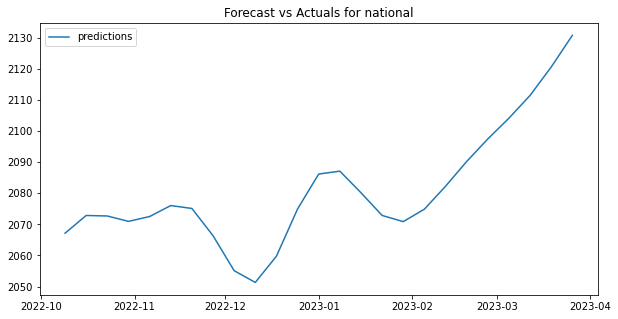

In [15]:
if __name__ == '__main__':
    avg_ner_data = raot_cta_ner.groupby(['WEEK_START']).agg({'NER_T4':'mean'}).reset_index()

    ## experimenting with a dataset
    prediction_period = 25
    algorithm_name = 'Prophet Model'
    
    results = prophet_model(algorithm_name, prediction_period)
    df_train = results.transformation(avg_ner_data, 'WEEK_START', 'NER_T4')
    results.fit_model(df_train)
    predictions = results.predict()
    #results.evaluation(df_test, predictions)
    results.plot(predictions, 'national')

# MSA Level

In [16]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4').reset_index()

15:34:33 - cmdstanpy - INFO - Chain [1] start processing
15:34:33 - cmdstanpy - INFO - Chain [1] done processing


Atlanta, GA


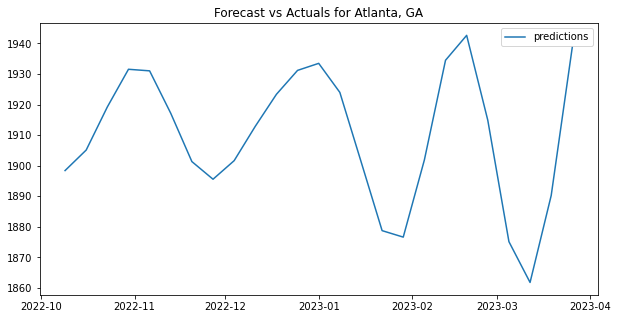

15:34:37 - cmdstanpy - INFO - Chain [1] start processing


Austin, TX


15:34:37 - cmdstanpy - INFO - Chain [1] done processing


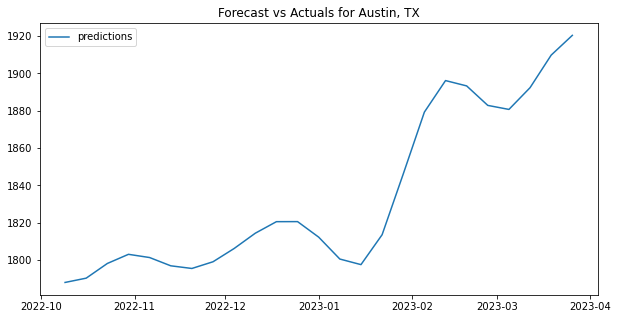

15:34:38 - cmdstanpy - INFO - Chain [1] start processing
15:34:38 - cmdstanpy - INFO - Chain [1] done processing


Baltimore, MD


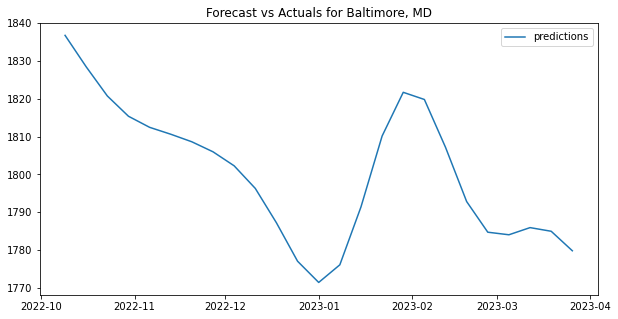

15:34:40 - cmdstanpy - INFO - Chain [1] start processing
15:34:40 - cmdstanpy - INFO - Chain [1] done processing


Boston, MA


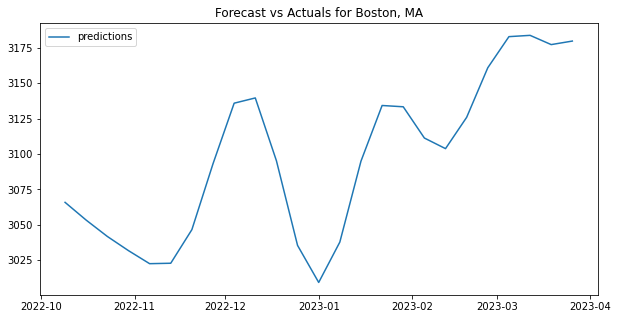

15:34:42 - cmdstanpy - INFO - Chain [1] start processing
15:34:42 - cmdstanpy - INFO - Chain [1] done processing


Charleston, SC


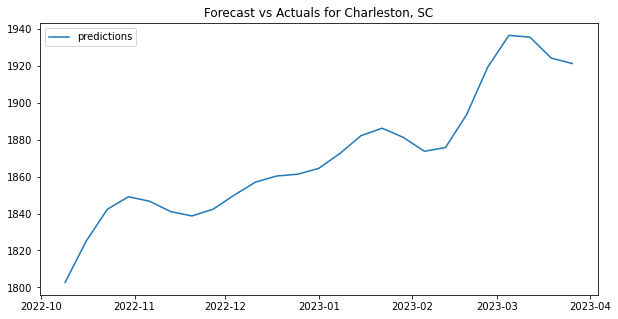

15:34:43 - cmdstanpy - INFO - Chain [1] start processing
15:34:43 - cmdstanpy - INFO - Chain [1] done processing


Charlotte, NC


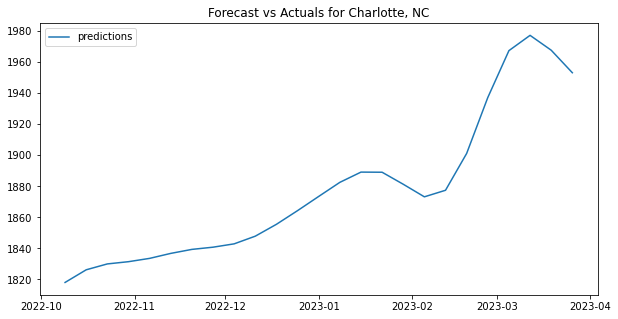

15:34:45 - cmdstanpy - INFO - Chain [1] start processing
15:34:45 - cmdstanpy - INFO - Chain [1] done processing


Chicago, IL


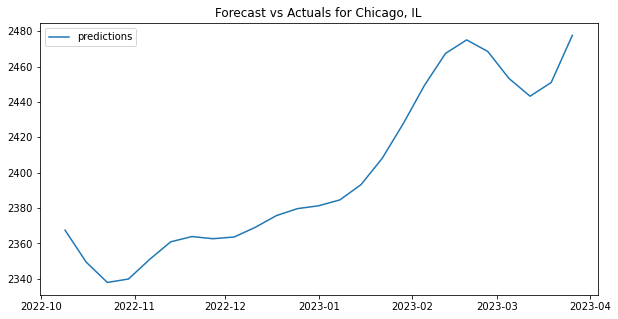

15:34:46 - cmdstanpy - INFO - Chain [1] start processing
15:34:47 - cmdstanpy - INFO - Chain [1] done processing


Dallas, TX


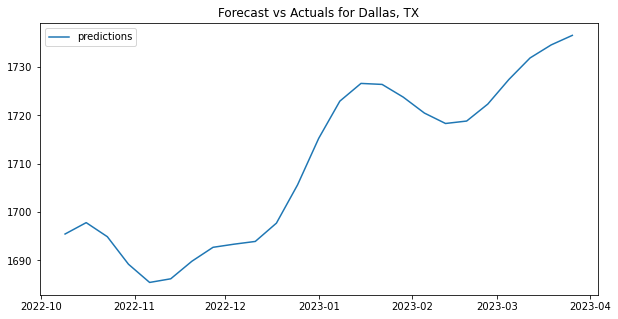

15:34:48 - cmdstanpy - INFO - Chain [1] start processing
15:34:48 - cmdstanpy - INFO - Chain [1] done processing


Denver, CO


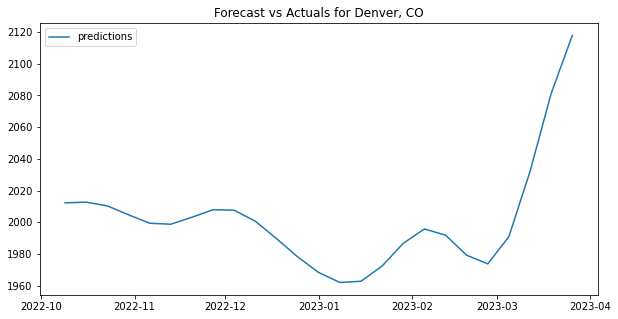

15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing


Houston, TX


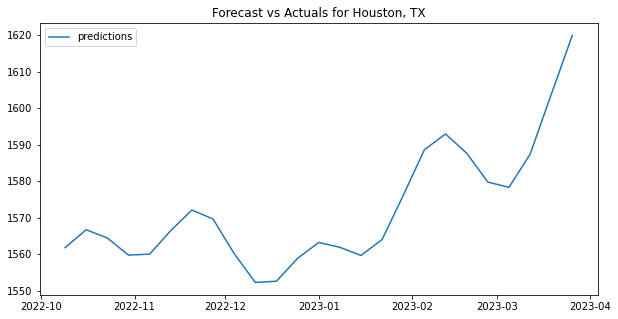

15:34:51 - cmdstanpy - INFO - Chain [1] start processing
15:34:51 - cmdstanpy - INFO - Chain [1] done processing


Jacksonville, FL


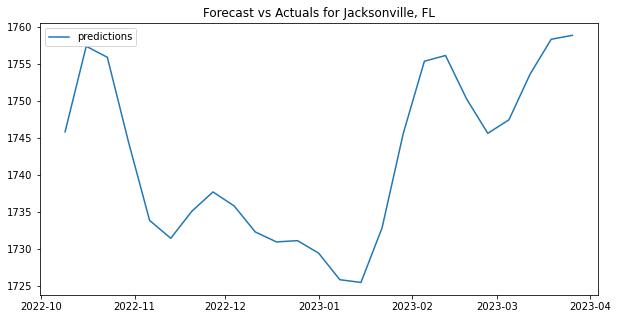

15:34:53 - cmdstanpy - INFO - Chain [1] start processing
15:34:53 - cmdstanpy - INFO - Chain [1] done processing


Las Vegas, NV


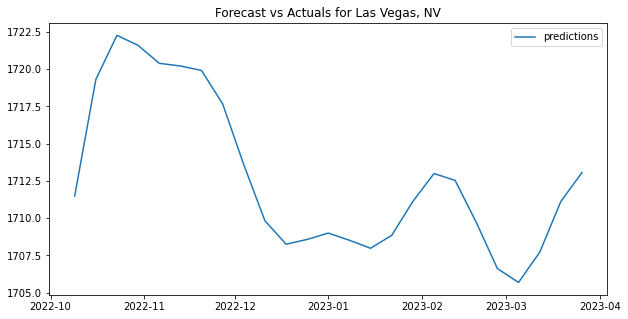

15:34:54 - cmdstanpy - INFO - Chain [1] start processing
15:34:54 - cmdstanpy - INFO - Chain [1] done processing


Los Angeles, CA


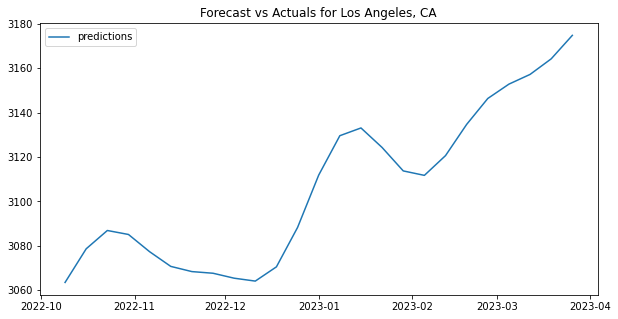

15:34:56 - cmdstanpy - INFO - Chain [1] start processing
15:34:56 - cmdstanpy - INFO - Chain [1] done processing


Miami, FL


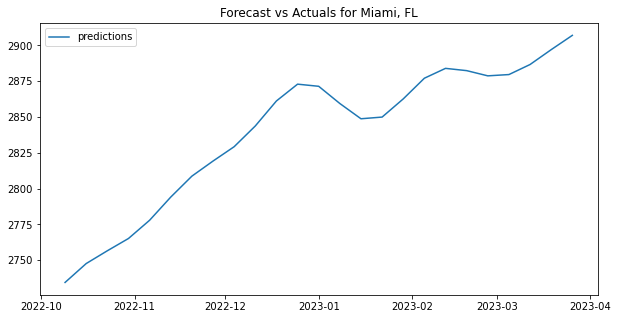

15:34:58 - cmdstanpy - INFO - Chain [1] start processing
15:34:58 - cmdstanpy - INFO - Chain [1] done processing


Nashville, TN


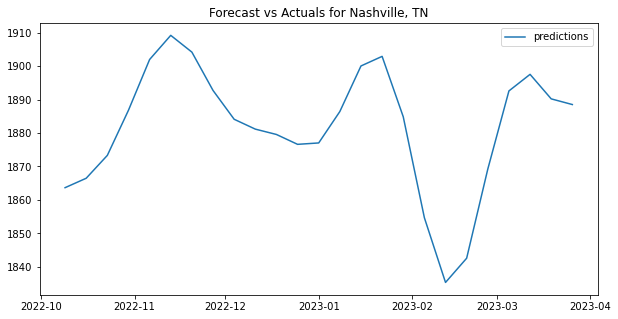

15:34:59 - cmdstanpy - INFO - Chain [1] start processing
15:34:59 - cmdstanpy - INFO - Chain [1] done processing


New York, NY


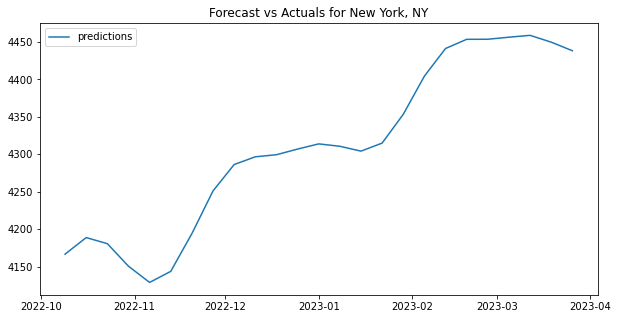

15:35:01 - cmdstanpy - INFO - Chain [1] start processing
15:35:01 - cmdstanpy - INFO - Chain [1] done processing


Orlando, FL


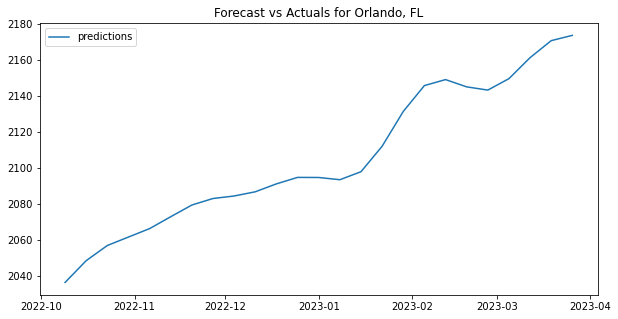

15:35:02 - cmdstanpy - INFO - Chain [1] start processing
15:35:03 - cmdstanpy - INFO - Chain [1] done processing


Phoenix, AZ


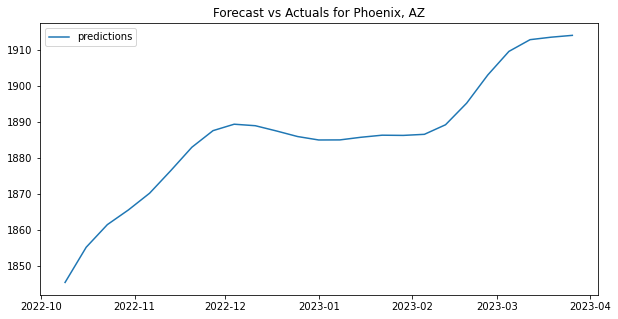

15:35:04 - cmdstanpy - INFO - Chain [1] start processing
15:35:04 - cmdstanpy - INFO - Chain [1] done processing


Portland, OR


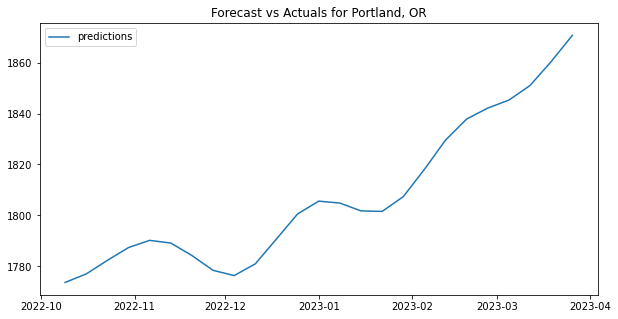

15:35:06 - cmdstanpy - INFO - Chain [1] start processing
15:35:06 - cmdstanpy - INFO - Chain [1] done processing


Raleigh, NC


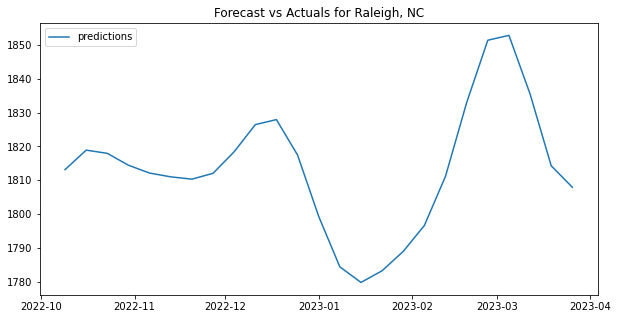

15:35:08 - cmdstanpy - INFO - Chain [1] start processing
15:35:08 - cmdstanpy - INFO - Chain [1] done processing


Riverside, CA


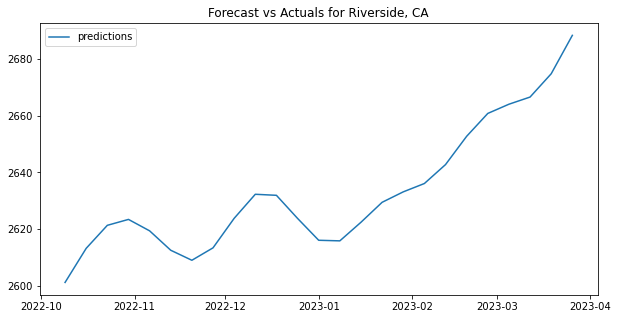

15:35:09 - cmdstanpy - INFO - Chain [1] start processing
15:35:09 - cmdstanpy - INFO - Chain [1] done processing


San Antonio, TX


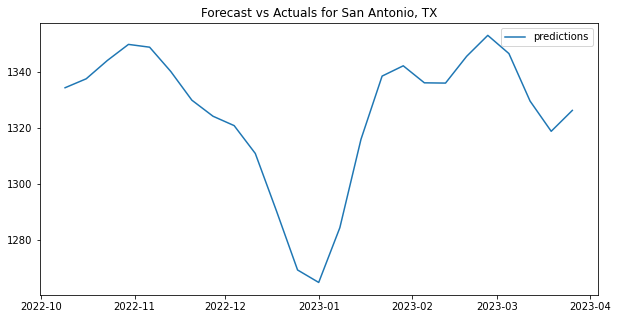

15:35:11 - cmdstanpy - INFO - Chain [1] start processing
15:35:11 - cmdstanpy - INFO - Chain [1] done processing


San Diego, CA


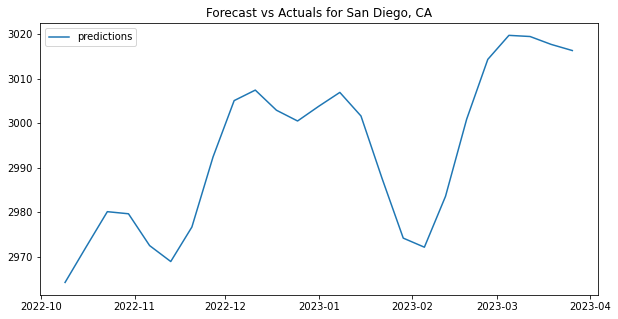

15:35:12 - cmdstanpy - INFO - Chain [1] start processing
15:35:13 - cmdstanpy - INFO - Chain [1] done processing


San Francisco, CA


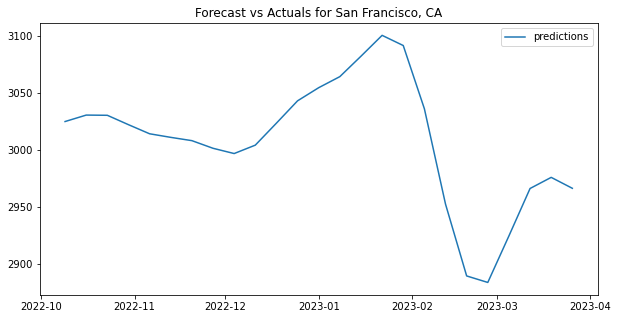

15:35:14 - cmdstanpy - INFO - Chain [1] start processing
15:35:14 - cmdstanpy - INFO - Chain [1] done processing


San Jose, CA


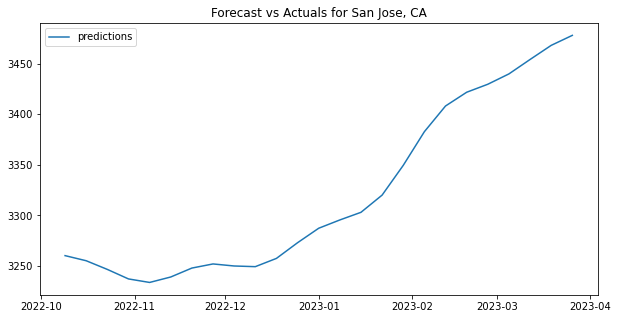

15:35:16 - cmdstanpy - INFO - Chain [1] start processing
15:35:16 - cmdstanpy - INFO - Chain [1] done processing


Seattle, WA


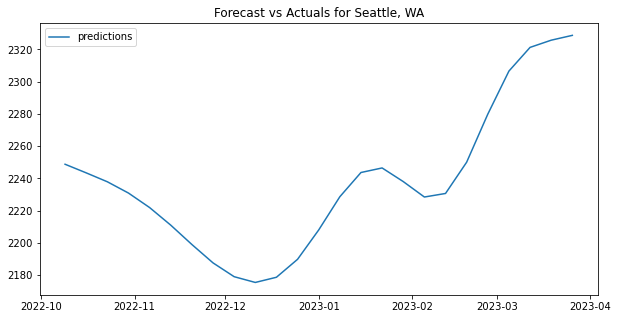

15:35:17 - cmdstanpy - INFO - Chain [1] start processing
15:35:17 - cmdstanpy - INFO - Chain [1] done processing


Tampa, FL


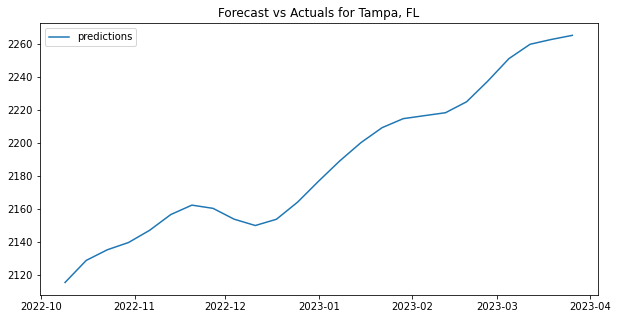

15:35:19 - cmdstanpy - INFO - Chain [1] start processing
15:35:19 - cmdstanpy - INFO - Chain [1] done processing


Washington, DC


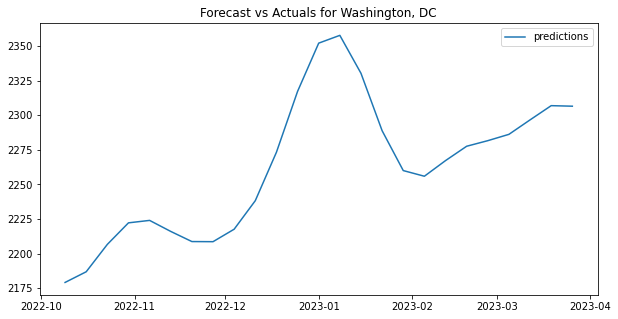

In [17]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Prophet Model'

        results = prophet_model(algorithm_name, prediction_period)
        print(unique_val)

        df_train = results.transformation(subset, 'WEEK_START', 'NER_T4')        
        
        results.fit_model(df_train)
        predictions = results.predict()
        #results.evaluation(predictions)
        results.plot(predictions, unique_val)

**Extracting the data into a df**

In [18]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])

subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4').reset_index()

In [19]:
column_names = ["Model", "Time", "MSA", "Predictions"]

df_prophet = pd.DataFrame(columns = column_names)
df_prophet

,Model,Time,MSA,Predictions


In [20]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Predictions"]

        df = pd.DataFrame(columns = column_names)
        df

        ## experimenting with a dataset
        prediction_period = 25
        algorithm_name = 'Prophet Model'

        results = prophet_model(algorithm_name, prediction_period)
        
        
        df_train = results.transformation(subset, 'WEEK_START', 'NER_T4')
        
        
        results.fit_model(df_train)
        predictions = results.predict()
        #mape_score = results.evaluation(df_test, predictions)        
        #df['Actuals'] =  df_test['y']
        df['Predictions'] =  predictions['yhat']
        #df['MAPE score'] =  mape_score
        df['Time'] =  predictions['ds']
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val

        
        #results.evaluation(df_test, predictions)
        df_prophet = df_prophet.append(df, ignore_index=True)

15:36:05 - cmdstanpy - INFO - Chain [1] start processing
15:36:05 - cmdstanpy - INFO - Chain [1] done processing
15:36:06 - cmdstanpy - INFO - Chain [1] start processing
15:36:06 - cmdstanpy - INFO - Chain [1] done processing
15:36:07 - cmdstanpy - INFO - Chain [1] start processing
15:36:07 - cmdstanpy - INFO - Chain [1] done processing
15:36:09 - cmdstanpy - INFO - Chain [1] start processing
15:36:09 - cmdstanpy - INFO - Chain [1] done processing
15:36:10 - cmdstanpy - INFO - Chain [1] start processing
15:36:10 - cmdstanpy - INFO - Chain [1] done processing
15:36:12 - cmdstanpy - INFO - Chain [1] start processing
15:36:12 - cmdstanpy - INFO - Chain [1] done processing
15:36:13 - cmdstanpy - INFO - Chain [1] start processing
15:36:13 - cmdstanpy - INFO - Chain [1] done processing
15:36:15 - cmdstanpy - INFO - Chain [1] start processing
15:36:15 - cmdstanpy - INFO - Chain [1] done processing
15:36:17 - cmdstanpy - INFO - Chain [1] start processing
15:36:17 - cmdstanpy - INFO - Chain [1]

In [21]:
df_prophet['Hash Column'] = df_prophet['MSA'] + df_prophet['Time'].astype(str)

In [22]:
df_prophet

,Model,Time,MSA,Predictions,Hash Column
0,Prophet Model,2022-10-09,"Atlanta, GA",1898.401779,"Atlanta, GA2022-10-09"
1,Prophet Model,2022-10-16,"Atlanta, GA",1905.117121,"Atlanta, GA2022-10-16"
2,Prophet Model,2022-10-23,"Atlanta, GA",1919.210593,"Atlanta, GA2022-10-23"
3,Prophet Model,2022-10-30,"Atlanta, GA",1931.532008,"Atlanta, GA2022-10-30"
4,Prophet Model,2022-11-06,"Atlanta, GA",1931.018043,"Atlanta, GA2022-11-06"
...,...,...,...,...,...
695,Prophet Model,2023-02-26,"Washington, DC",2281.592366,"Washington, DC2023-02-26"
696,Prophet Model,2023-03-05,"Washington, DC",2286.163950,"Washington, DC2023-03-05"
697,Prophet Model,2023-03-12,"Washington, DC",2296.618273,"Washington, DC2023-03-12"
698,Prophet Model,2023-03-19,"Washington, DC",2306.896205,"Washington, DC2023-03-19"


In [23]:
df_prophet.to_csv("df_prophet_msa_level_FUTURE_FORECASTS.csv")